<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-CNN-Projects/blob/master/cat_vs_dog_vgg16/cat_vs_dog_vgg16_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import pathlib
import numpy as np

# Download Dataset

In [ ]:
from google.colab import userdata

os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

#!/bin/bash
!kaggle datasets download karakaggle/kaggle-cat-vs-dog-dataset
!unzip kaggle-cat-vs-dog-dataset.zip
!rm kaggle-cat-vs-dog-dataset.zip

*Remove Corrupted Images*

In [2]:
# Remove corrupted images
import os
from PIL import Image

num_skipped_images = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("/content/kagglecatsanddogs_3367a/PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped_images += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped_images} images.")

Deleted 0 images.


# Configuration

In [3]:
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
BASE_LEARNING_RATE = 1e-3
FINE_TUNE_LR = 1e-5
NUM_CLASSES = 2

# Load Data

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory="/content/kagglecatsanddogs_3367a/PetImages",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory="/content/kagglecatsanddogs_3367a/PetImages",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 23379 files belonging to 2 classes.
Using 18704 files for training.
Found 23379 files belonging to 2 classes.
Using 4675 files for validation.


# Check Samples

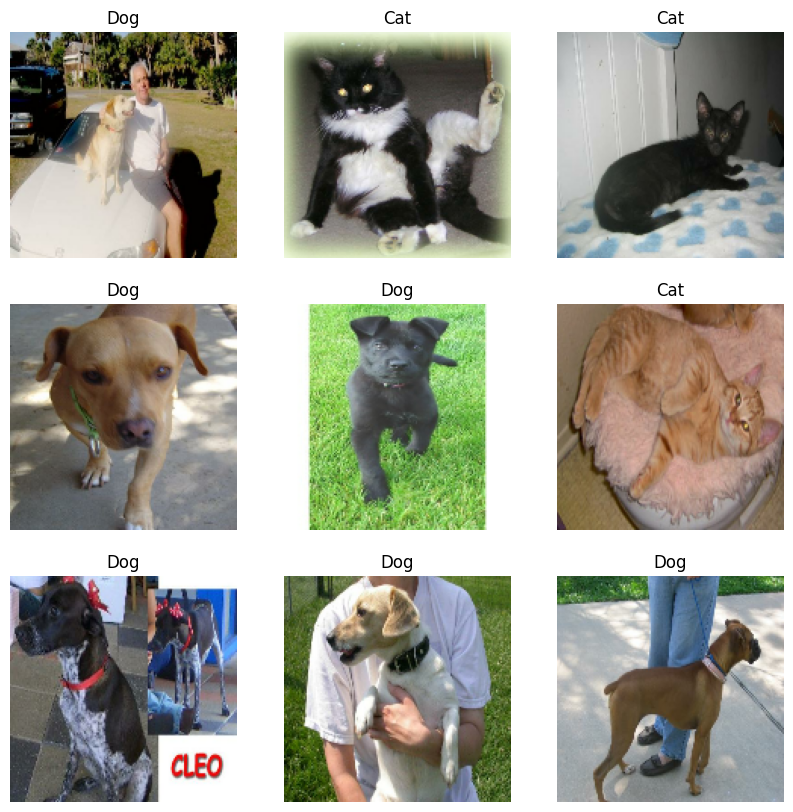

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image, label in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[np.argmax(label[i])])
        plt.axis("off")

# Preprocess Images

In [6]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_image(image, label):
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image, label


train_ds = train_ds.map(preprocess_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.map(preprocess_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Load `VGG16`

In [7]:
try:
    base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=IMAGE_SIZE + (3,))
    print(f"VGG16 Loaded.")
except Exception as e:
    print(f"Error: {e}")

VGG16 Loaded.


In [8]:
# Add new Head
def build_model(base_model, num_classes):
    inputs = Input(shape=IMAGE_SIZE + (3, ))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, outputs)
    return model

model = build_model(base_model, NUM_CLASSES)

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,370 (57.14 MB)

 Trainable params: 14,978,370 (57.14 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [10]:
base_model.trainable = False

model.compile(
    optimizer=Adam(learning_rate=BASE_LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Training new Heads
INITIAL_EPOCHS=5
history_head = model.fit(
    train_ds,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_ds
)

Epoch 1/5
585/585 ━━━━━━━━━━━━━━━━━━━━ 99s 148ms/step - accuracy: 0.9278 - loss: 0.7950 - val_accuracy: 0.9716 - val_loss: 0.0835
Epoch 2/5
585/585 ━━━━━━━━━━━━━━━━━━━━ 118s 126ms/step - accuracy: 0.9691 - loss: 0.0903 - val_accuracy: 0.9716 - val_loss: 0.0747
Epoch 3/5
585/585 ━━━━━━━━━━━━━━━━━━━━ 74s 127ms/step - accuracy: 0.9735 - loss: 0.0750 - val_accuracy: 0.9763 - val_loss: 0.0722
Epoch 4/5
585/585 ━━━━━━━━━━━━━━━━━━━━ 74s 126ms/step - accuracy: 0.9757 - loss: 0.0649 - val_accuracy: 0.9728 - val_loss: 0.0826
Epoch 5/5
585/585 ━━━━━━━━━━━━━━━━━━━━ 74s 126ms/step - accuracy: 0.9784 - loss: 0.0582 - val_accuracy: 0.9728 - val_loss: 0.0828


# Fine Tune

In [11]:
base_model.trainable=True

fine_tune_at = 11
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Number of Freezed Layers: {fine_tune_at}")
print(f"Number of Opne Layers: {len(base_model.layers) - fine_tune_at}")


# Compile
model.compile(
    optimizer=Adam(learning_rate=FINE_TUNE_LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Training
FINE_TUNE_EPOCHS = 15
total_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
history_ft = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history_head.epoch[-1],
    validation_data=validation_ds
)

Number of Freezed Layers: 11
Number of Opne Layers: 8
Epoch 5/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 127s 199ms/step - accuracy: 0.9796 - loss: 0.0535 - val_accuracy: 0.9748 - val_loss: 0.0815
Epoch 6/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 109s 187ms/step - accuracy: 0.9916 - loss: 0.0219 - val_accuracy: 0.9780 - val_loss: 0.0668
Epoch 7/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 109s 187ms/step - accuracy: 0.9952 - loss: 0.0131 - val_accuracy: 0.9780 - val_loss: 0.0672
Epoch 8/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 109s 187ms/step - accuracy: 0.9973 - loss: 0.0091 - val_accuracy: 0.9801 - val_loss: 0.0663
Epoch 9/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 109s 187ms/step - accuracy: 0.9977 - loss: 0.0068 - val_accuracy: 0.9775 - val_loss: 0.0809
Epoch 10/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 109s 187ms/step - accuracy: 0.9986 - loss: 0.0054 - val_accuracy: 0.9756 - val_loss: 0.0919
Epoch 11/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 109s 187ms/step - accuracy: 0.9941 - loss: 0.0236 - val_accuracy: 0.9793 - val_loss: 0.0969
Epoch 12/20
585/585 

# Evaluation

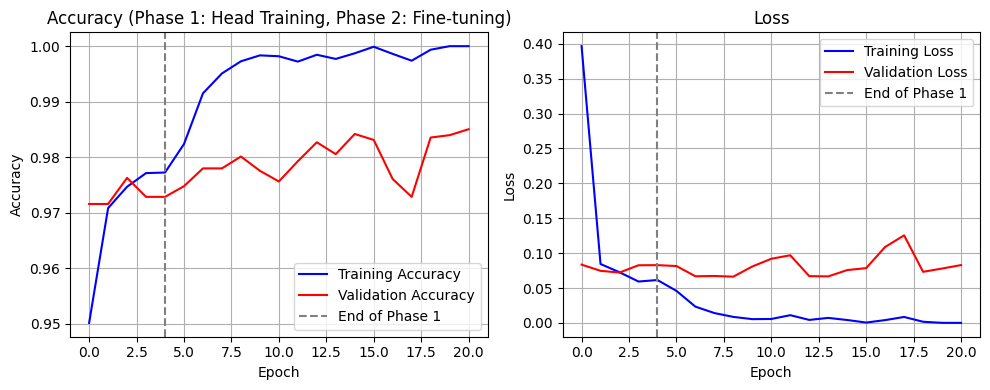

In [13]:
def plot_fine_tuning_curves(history_head, history_ft, initial_epochs):
    # Combine history from both phases
    acc = history_head.history['accuracy'] + history_ft.history['accuracy']
    val_acc = history_head.history['val_accuracy'] + history_ft.history['val_accuracy']
    loss = history_head.history['loss'] + history_ft.history['loss']
    val_loss = history_head.history['val_loss'] + history_ft.history['val_loss']

    epochs_range = range(len(acc)) # Total number of epochs

    plt.figure(figsize=(10, 4))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red')
    plt.axvline(x=initial_epochs - 1, color='gray', linestyle='--', label='End of Phase 1')
    plt.legend(loc='lower right')
    plt.title('Accuracy (Phase 1: Head Training, Phase 2: Fine-tuning)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='red')
    plt.axvline(x=initial_epochs - 1, color='gray', linestyle='--', label='End of Phase 1')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_fine_tuning_curves(history_head, history_ft, INITIAL_EPOCHS)